Matthew Larsen Final Project

First thing I will do is read in the data. This dataset comes from https://www.kaggle.com/datasets/abdulszz/spotify-most-streamed-songs/data

It contains about 1000 of the most popular songs on Spotify. The dataset can be broken down into 3 main feature sets.

1. Basic Track Info
2. Streaming Metrics
3. Musical Attributes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

data = pd.read_csv("Spotify Most Streamed Songs.csv")

basic_track_info_features = ["track_name", "artist(s)_name", "artist_count", "released_year", "released_month", "released_day", "cover_url"]
streaming_metric_features = ["in_spotify_playlists", "in_spotify_charts", "streams", "in_apple_playlists", "in_apple_charts", "in_deezer_playlists", "in_deezer_charts", "in_shazam_charts"]
musical_attribute_features = ["bpm", "key", "mode", "danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"]

data

track_name      artist(s)_name  artist_count  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook             2   
1                                   LALA         Myke Towers             1   
2                                vampire      Olivia Rodrigo             1   
3                           Cruel Summer        Taylor Swift             1   
4                         WHERE SHE GOES           Bad Bunny             1   
..                                   ...                 ...           ...   
948                         My Mind & Me        Selena Gomez             1   
949            Bigger Than The Whole Sky        Taylor Swift             1   
950                 A Veces (feat. Feid)  Feid, Paulo Londra             2   
951                        En La De Ella  Feid, Sech, Jhayco             3   
952                                Alone           Burna Boy             1   

     released_year  released_month  released_day  in_spotify_playlists  \
0             2023               7            14                   553   
1             2023               3            23                  1474   
2             2023               6            30                  1397   
3             2019               8            23                  7858   
4             2023               5            18                  3133   
..             ...             ...           ...                   ...   
948           2022              11             3                   953   
949           2022              10            21                  1180   
950           2022              11             3                   573   
951           2022              10            20                  1320   
952           2022              11             4                   782   

     in_spotify_charts    streams  in_apple_playlists  ...  key   mode  \
0                  147  141381703                  43  ...    B  Major   
1                   48  133716286                  48  ...   C#  Major   
2                  113  140003974                  94  ...    F  Major   
3                  100  800840817                 116  ...    A  Major   
4                   50  303236322                  84  ...    A  Minor   
..                 ...        ...                 ...  ...  ...    ...   
948                  0   91473363                  61  ...    A  Major   
949                  0  121871870                   4  ...   F#  Major   
950                  0   73513683                   2  ...   C#  Major   
951                  0  133895612                  29  ...   C#  Major   
952                  2   96007391                  27  ...    E  Minor   

     danceability_% valence_%  energy_% acousticness_% instrumentalness_%  \
0                80        89        83             31                  0   
1                71        61        74              7                  0   
2                51        32        53             17                  0   
3                55        58        72             11                  0   
4                65        23        80             14                 63   
..              ...       ...       ...            ...                ...   
948              60        24        39             57                  0   
949              42         7        24             83                  1   
950              80        81        67              4                  0   
951              82        67        77              8                  0   
952              61        32        67             15                  0   

     liveness_%  speechiness_%  \
0             8              4   
1            10              4   
2            31              6   
3            11             15   
4            11              6   
..          ...            ...   
948           8              3   
949          12              6   
950           8              6   
951          12              5   
952          11 

The first thing I want to do is observe the Streaming Metrics. I am most interested in the Spotify Metrics. I will observe the data using a series of box-and-whisker plots as well as reporting the min, average, and max for each feature.

Feature Name Min Avg Max
in_spotify_playlists 31 5200.12 52898
in_spotify_charts 0 12.01 147
streams 2762 513836306.67 3703895074


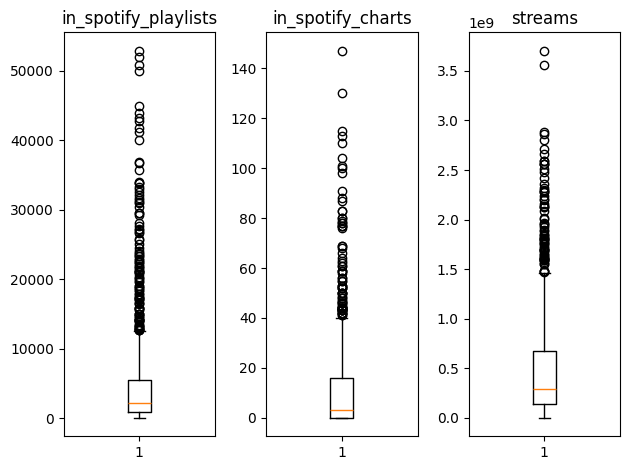

405


In [2]:
spotify_metric_features = ["in_spotify_playlists", "in_spotify_charts", "streams"]

# data["streams"] = data["streams"]/1000000
# Create box plots for streaming metric features
fig, axs = plt.subplots(1, len(spotify_metric_features))

print("Feature Name", "Min", "Avg", "Max")
for feature_index in range(len(spotify_metric_features)):
    feature = streaming_metric_features[feature_index]
    print(feature, data[feature].min(), round(data[feature].mean(), 2), data[feature].max())
    axs[feature_index].boxplot(data[feature])
    axs[feature_index].set_title(feature)

plt.tight_layout()
plt.show()

print(data[data['in_spotify_charts'] == 0]['track_name'].count());

I ran into two issues with invalid data. The first one was specific to the following entry.

Love Grows (Where My Rosemary Goes),Edison Lighthouse,1,1970,1,1,2877,0,BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3,16,0,54,0,0,110,A,Major,53,75,69,7,0,17,3,https://i.scdn.co/image/ab67616d0000b2739a0011cc9d31cf969b656905

It seems as though the number of streams this song has somehow got corrupted. To address this issue, I decided to estimate the number of streams for the song. I looked up some of the other songs on Spotify, calculating the ratio of the number of streams reported in the dataset to the live data on Spotify's website. It was roughly 80%. Then I took that 80% and multiplied the live data for this song by that amount to get approximately 227,171,713 streams for this song.

The second issue I am seeing is related to the in_spotify_charts feature. Some of the songs (close to half) have a ranking of 0. A ranking of 0 doesn't make sense and with so many songs having that ranking, my assumption is that if a song was not in the top 150 songs or so that the person who collected the data simply assigned a 0. I would like to consider songs which were ranked and those that weren't separately so I am going to create a new feature to categorize them. 

In [3]:
data['is_ranked_in_spotify_charts'] = data['in_spotify_charts'] > 0
data

track_name      artist(s)_name  artist_count  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook             2   
1                                   LALA         Myke Towers             1   
2                                vampire      Olivia Rodrigo             1   
3                           Cruel Summer        Taylor Swift             1   
4                         WHERE SHE GOES           Bad Bunny             1   
..                                   ...                 ...           ...   
948                         My Mind & Me        Selena Gomez             1   
949            Bigger Than The Whole Sky        Taylor Swift             1   
950                 A Veces (feat. Feid)  Feid, Paulo Londra             2   
951                        En La De Ella  Feid, Sech, Jhayco             3   
952                                Alone           Burna Boy             1   

     released_year  released_month  released_day  in_spotify_playlists  \
0             2023               7            14                   553   
1             2023               3            23                  1474   
2             2023               6            30                  1397   
3             2019               8            23                  7858   
4             2023               5            18                  3133   
..             ...             ...           ...                   ...   
948           2022              11             3                   953   
949           2022              10            21                  1180   
950           2022              11             3                   573   
951           2022              10            20                  1320   
952           2022              11             4                   782   

     in_spotify_charts    streams  in_apple_playlists  ...   mode  \
0                  147  141381703                  43  ...  Major   
1                   48  133716286                  48  ...  Major   
2                  113  140003974                  94  ...  Major   
3                  100  800840817                 116  ...  Major   
4                   50  303236322                  84  ...  Minor   
..                 ...        ...                 ...  ...    ...   
948                  0   91473363                  61  ...  Major   
949                  0  121871870                   4  ...  Major   
950                  0   73513683                   2  ...  Major   
951                  0  133895612                  29  ...  Major   
952                  2   96007391                  27  ...  Minor   

    danceability_%  valence_% energy_%  acousticness_% instrumentalness_%  \
0               80         89       83              31                  0   
1               71         61       74               7                  0   
2               51         32       53              17                  0   
3               55         58       72              11                  0   
4               65         23       80              14                 63   
..             ...        ...      ...             ...                ...   
948             60         24       39              57                  0   
949             42          7       24              83                  1   
950             80         81       67               4                  0   
951             82         67       77               8                  0   
952             61         32       67              15                  0   

    liveness_%  speechiness_%  \
0            8              4   
1           10              4   
2           31              6   
3           11             15   
4           11              6   
..         ...            ...   
948          8              3   
949         12              6   
950          8              6   
951         12              5   
952         11              5   

                                             cover_ur

Making that adjustment, we can calculate a new min, average, and max for those songs which are ranked

ranked_in_spotify_charts 1 20.89 147 548


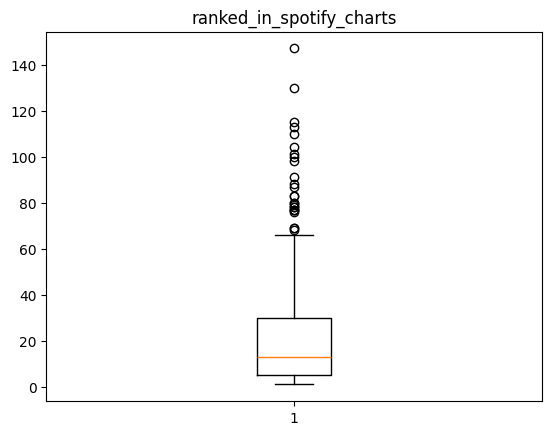

In [4]:
ranked_spotify_charts = data[data['is_ranked_in_spotify_charts'] == True]['in_spotify_charts']
print("ranked_in_spotify_charts", ranked_spotify_charts.min(), round(ranked_spotify_charts.mean(), 2), ranked_spotify_charts.max(), ranked_spotify_charts.count())
plt.boxplot(ranked_spotify_charts)
plt.title("ranked_in_spotify_charts")
plt.show()

The next thing I would like to look at is how each of the spotify_metric_features relate to each other. A good way to visualize this is with a scatter matrix. The ranked songs are displayed in red while the unranked songs are displayed in blue.

array([[<Axes: xlabel='in_spotify_playlists', ylabel='in_spotify_playlists'>,
        <Axes: xlabel='in_spotify_charts', ylabel='in_spotify_playlists'>,
        <Axes: xlabel='streams', ylabel='in_spotify_playlists'>],
       [<Axes: xlabel='in_spotify_playlists', ylabel='in_spotify_charts'>,
        <Axes: xlabel='in_spotify_charts', ylabel='in_spotify_charts'>,
        <Axes: xlabel='streams', ylabel='in_spotify_charts'>],
       [<Axes: xlabel='in_spotify_playlists', ylabel='streams'>,
        <Axes: xlabel='in_spotify_charts', ylabel='streams'>,
        <Axes: xlabel='streams', ylabel='streams'>]], dtype=object)

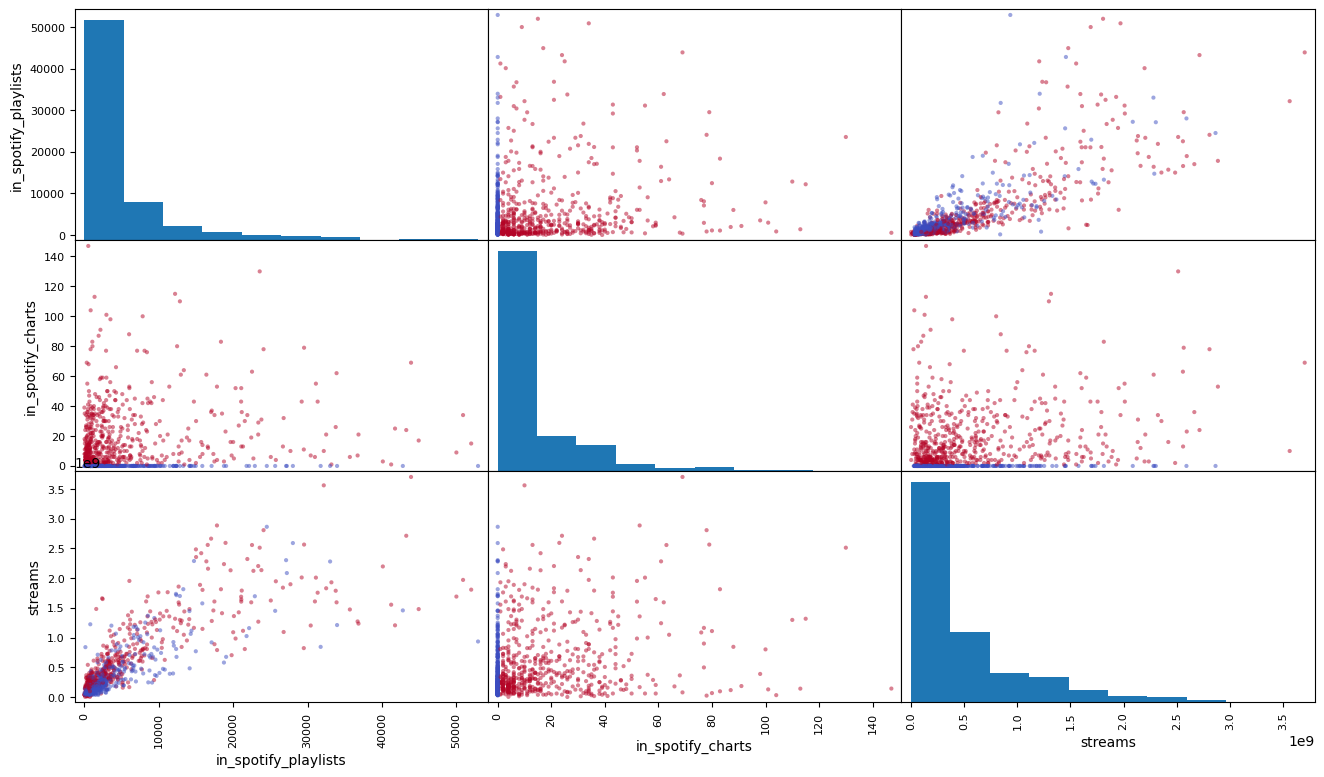

In [5]:
pd.plotting.scatter_matrix(data[spotify_metric_features], figsize=(16, 9), c=data['is_ranked_in_spotify_charts'], cmap="coolwarm")

Between the boxplots and these scatter plots, it is obvious that the number of streams a song has and the number of playlists a song appears in are heavily skewed features. I think we can help account for this using logarithmic transformation to normalize the distribution. For the in_spotify_charts feature, I want to invert the rankings so that ranked songs have a higher value.

Feature Name Min Avg Max
log_in_spotify_playlists 3.4339872044851463 7.72 10.876120809948317
inverted_in_spotify_charts 0 74.82 150
log_streams 7.923710333969238 19.51 22.032650825575328


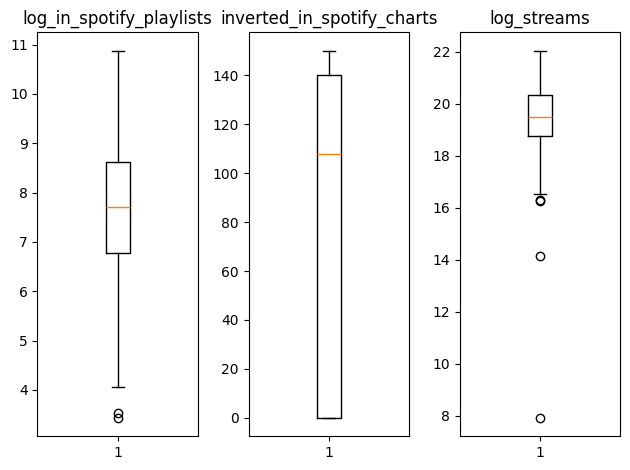

array([[<Axes: xlabel='log_in_spotify_playlists', ylabel='log_in_spotify_playlists'>,
        <Axes: xlabel='inverted_in_spotify_charts', ylabel='log_in_spotify_playlists'>,
        <Axes: xlabel='log_streams', ylabel='log_in_spotify_playlists'>],
       [<Axes: xlabel='log_in_spotify_playlists', ylabel='inverted_in_spotify_charts'>,
        <Axes: xlabel='inverted_in_spotify_charts', ylabel='inverted_in_spotify_charts'>,
        <Axes: xlabel='log_streams', ylabel='inverted_in_spotify_charts'>],
       [<Axes: xlabel='log_in_spotify_playlists', ylabel='log_streams'>,
        <Axes: xlabel='inverted_in_spotify_charts', ylabel='log_streams'>,
        <Axes: xlabel='log_streams', ylabel='log_streams'>]], dtype=object)

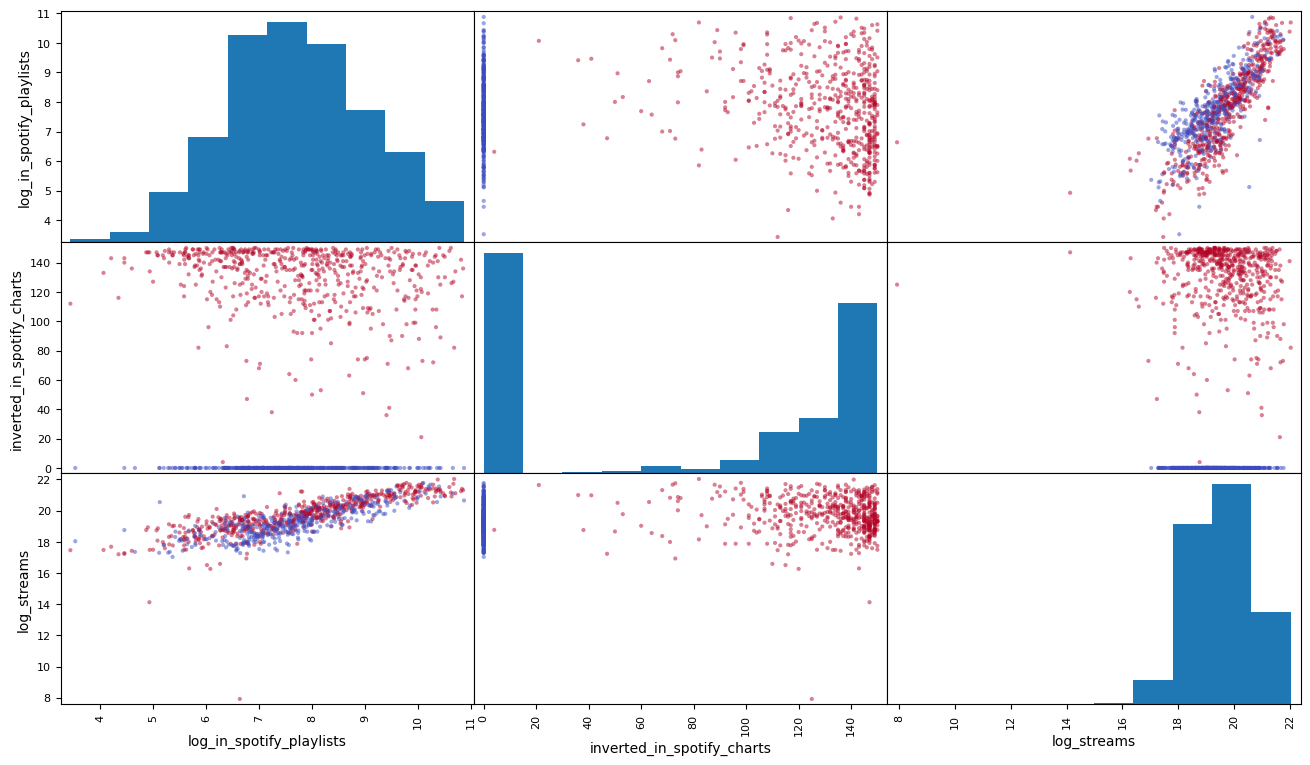

In [6]:
data['log_in_spotify_playlists'] = np.log(data['in_spotify_playlists'])
data['log_streams'] = np.log(data['streams'])
data['inverted_in_spotify_charts'] = data['in_spotify_charts'].apply(lambda x: 0 if x == 0 else 151 - x) 

log_spotify_metric_features = ["log_in_spotify_playlists", "inverted_in_spotify_charts", "log_streams"]

fig, axs = plt.subplots(1, len(log_spotify_metric_features))

print("Feature Name", "Min", "Avg", "Max")
for feature_index in range(len(log_spotify_metric_features)):
    feature = log_spotify_metric_features[feature_index]
    print(feature, data[feature].min(), round(data[feature].mean(), 2), data[feature].max())
    axs[feature_index].boxplot(data[feature])
    axs[feature_index].set_title(feature)

plt.tight_layout()
plt.show()

pd.plotting.scatter_matrix(data[log_spotify_metric_features], figsize=(16, 9), c=data['is_ranked_in_spotify_charts'], cmap="coolwarm")

Finally, we can perform standardization on the log_in_spotify_playlists and log_streams features so that they have a mean of 0 and a standard deviation of 1. I am hopeful that by doing so, we will be able to better estimate how a song might perform given its various musical attributes.

standardized_in_spotify_playlists -3.2196731766675453 -0.0 2.375004315601884
standardized_in_spotify_charts -1.1262323843846125 0.0 1.1316658716183658
standardized_streams -10.114785384149522 0.0 2.206124890296055


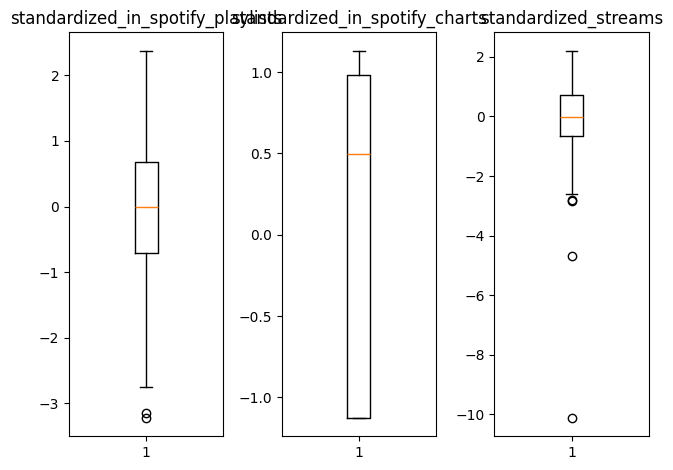

array([[<Axes: xlabel='standardized_in_spotify_playlists', ylabel='standardized_in_spotify_playlists'>,
        <Axes: xlabel='standardized_in_spotify_charts', ylabel='standardized_in_spotify_playlists'>,
        <Axes: xlabel='standardized_streams', ylabel='standardized_in_spotify_playlists'>],
       [<Axes: xlabel='standardized_in_spotify_playlists', ylabel='standardized_in_spotify_charts'>,
        <Axes: xlabel='standardized_in_spotify_charts', ylabel='standardized_in_spotify_charts'>,
        <Axes: xlabel='standardized_streams', ylabel='standardized_in_spotify_charts'>],
       [<Axes: xlabel='standardized_in_spotify_playlists', ylabel='standardized_streams'>,
        <Axes: xlabel='standardized_in_spotify_charts', ylabel='standardized_streams'>,
        <Axes: xlabel='standardized_streams', ylabel='standardized_streams'>]],
      dtype=object)

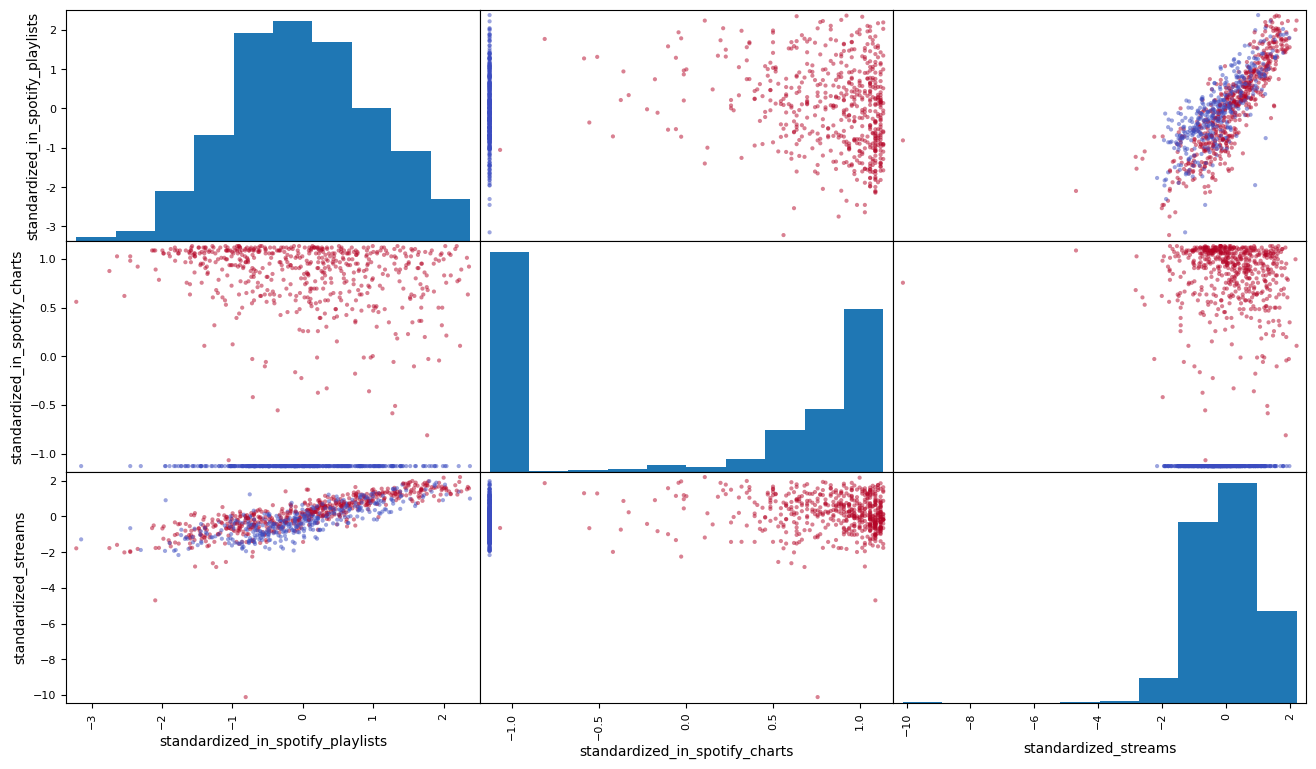

In [7]:
scaler = StandardScaler()

data['standardized_in_spotify_playlists'] = scaler.fit_transform(data[['log_in_spotify_playlists']])
data['standardized_in_spotify_charts'] = scaler.fit_transform(data[['inverted_in_spotify_charts']])
data['standardized_streams'] = scaler.fit_transform(data[['log_streams']])

standardized_spotify_metric_features = ["standardized_in_spotify_playlists", "standardized_in_spotify_charts", "standardized_streams"]

fig, axs = plt.subplots(1, len(standardized_spotify_metric_features))

for feature_index in range(len(standardized_spotify_metric_features)):
    feature = standardized_spotify_metric_features[feature_index]
    print(feature, data[feature].min(), round(data[feature].mean(), 2), data[feature].max())
    axs[feature_index].boxplot(data[feature])
    axs[feature_index].set_title(feature)

plt.tight_layout()
plt.show()

pd.plotting.scatter_matrix(data[standardized_spotify_metric_features], figsize=(16, 9), c=data['is_ranked_in_spotify_charts'], cmap="coolwarm")

Finally, I can combine all of the spotify metrics into one feature using pca.

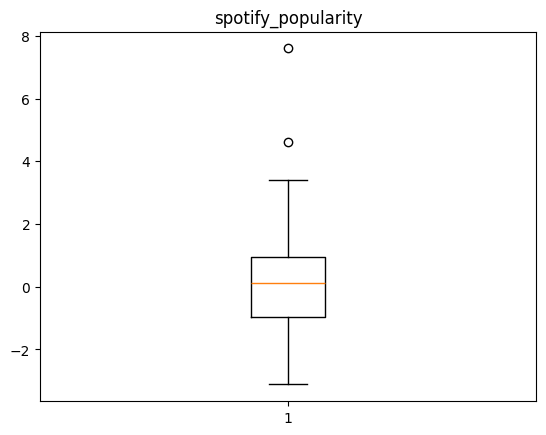

array([[<Axes: xlabel='standardized_in_spotify_playlists', ylabel='standardized_in_spotify_playlists'>,
        <Axes: xlabel='standardized_in_spotify_charts', ylabel='standardized_in_spotify_playlists'>,
        <Axes: xlabel='standardized_streams', ylabel='standardized_in_spotify_playlists'>,
        <Axes: xlabel='spotify_popularity', ylabel='standardized_in_spotify_playlists'>],
       [<Axes: xlabel='standardized_in_spotify_playlists', ylabel='standardized_in_spotify_charts'>,
        <Axes: xlabel='standardized_in_spotify_charts', ylabel='standardized_in_spotify_charts'>,
        <Axes: xlabel='standardized_streams', ylabel='standardized_in_spotify_charts'>,
        <Axes: xlabel='spotify_popularity', ylabel='standardized_in_spotify_charts'>],
       [<Axes: xlabel='standardized_in_spotify_playlists', ylabel='standardized_streams'>,
        <Axes: xlabel='standardized_in_spotify_charts', ylabel='standardized_streams'>,
        <Axes: xlabel='standardized_streams', ylabel='standar

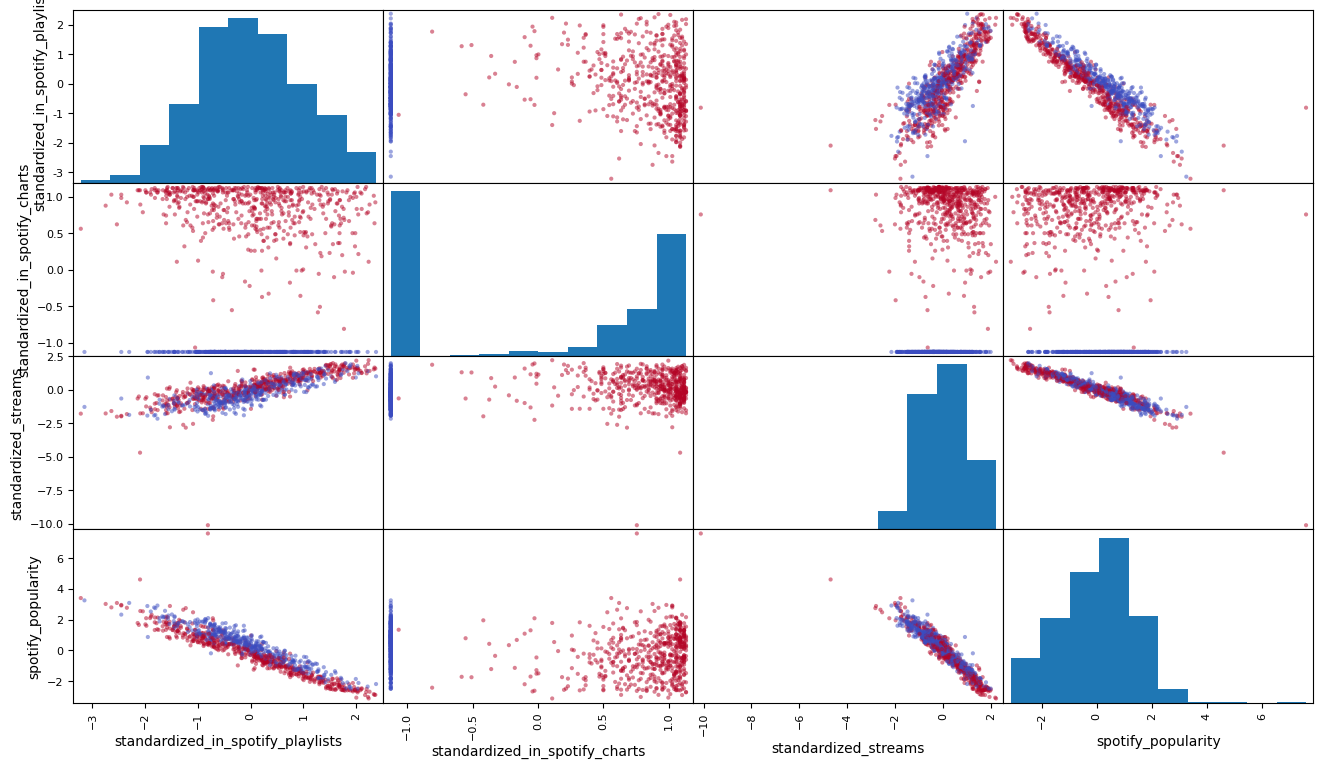

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
data['spotify_popularity'] = pca.fit_transform(data[standardized_spotify_metric_features])

standardized_spotify_metric_features.append('spotify_popularity')

plt.boxplot(data['spotify_popularity'])
plt.title("spotify_popularity")
plt.show()

pd.plotting.scatter_matrix(data[standardized_spotify_metric_features], figsize=(16, 9), c=data['is_ranked_in_spotify_charts'], cmap="coolwarm")

Now that I have some standardized streaming metrics to use, we can take a closer look at the musical attributes.

Feature Name Min Avg Max
bpm 65 122.54 206
danceability_% 23 66.97 96
valence_% 4 51.43 97
energy_% 9 64.28 97
acousticness_% 0 27.06 97
instrumentalness_% 0 1.58 91
liveness_% 3 18.21 97
speechiness_% 2 10.13 64
spotify_popularity -3.120838571966517 -0.0 7.600037690522802


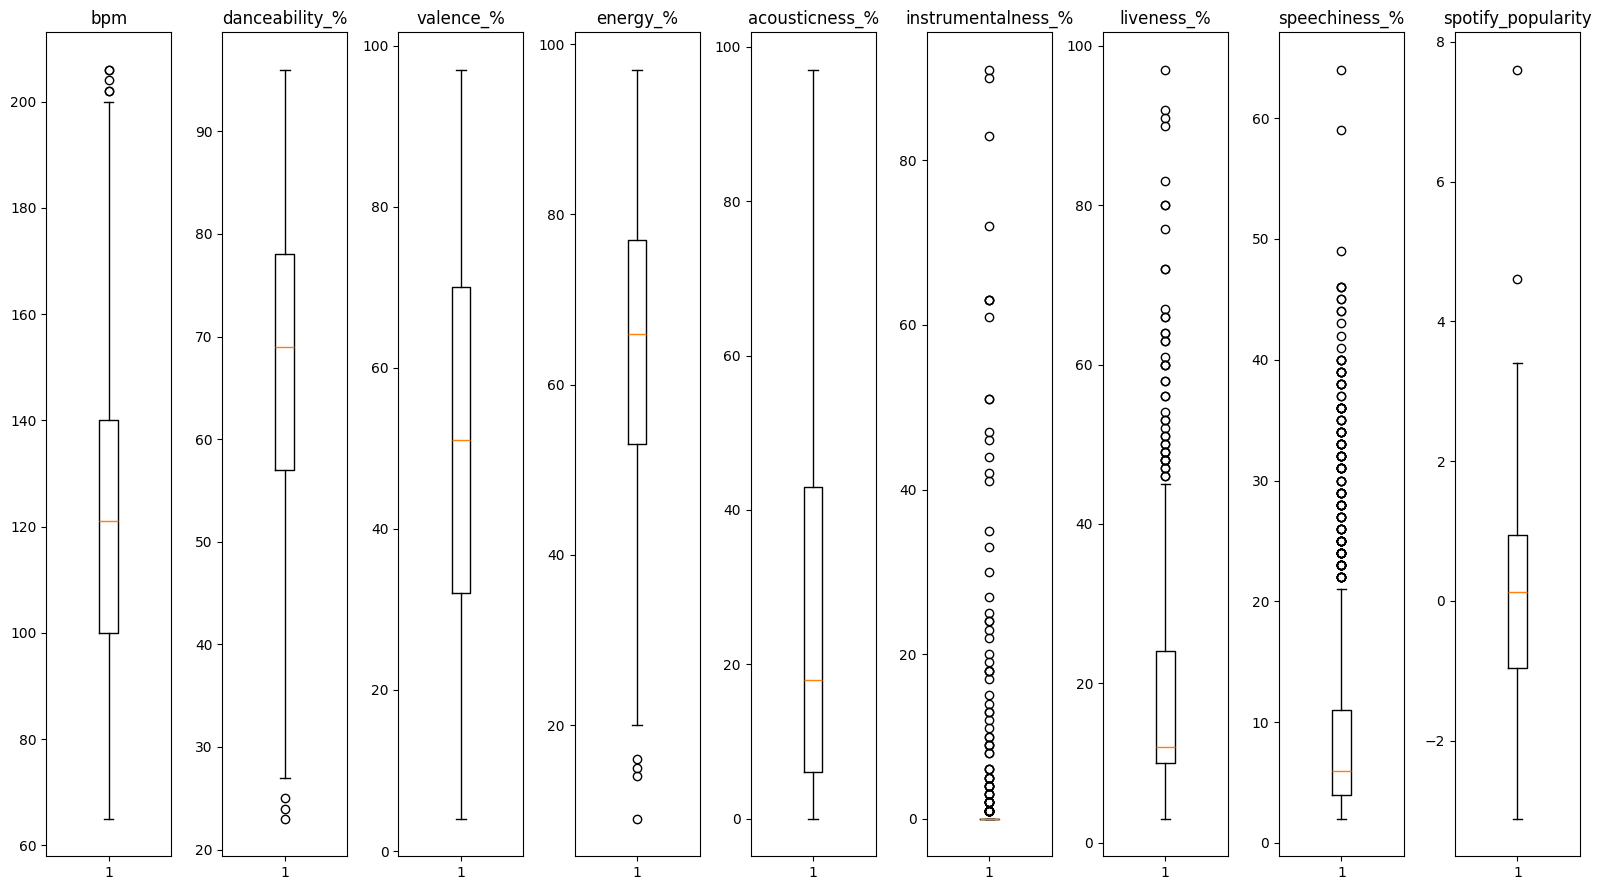

array([[<Axes: xlabel='bpm', ylabel='bpm'>,
        <Axes: xlabel='danceability_%', ylabel='bpm'>,
        <Axes: xlabel='valence_%', ylabel='bpm'>,
        <Axes: xlabel='energy_%', ylabel='bpm'>,
        <Axes: xlabel='acousticness_%', ylabel='bpm'>,
        <Axes: xlabel='instrumentalness_%', ylabel='bpm'>,
        <Axes: xlabel='liveness_%', ylabel='bpm'>,
        <Axes: xlabel='speechiness_%', ylabel='bpm'>,
        <Axes: xlabel='spotify_popularity', ylabel='bpm'>],
       [<Axes: xlabel='bpm', ylabel='danceability_%'>,
        <Axes: xlabel='danceability_%', ylabel='danceability_%'>,
        <Axes: xlabel='valence_%', ylabel='danceability_%'>,
        <Axes: xlabel='energy_%', ylabel='danceability_%'>,
        <Axes: xlabel='acousticness_%', ylabel='danceability_%'>,
        <Axes: xlabel='instrumentalness_%', ylabel='danceability_%'>,
        <Axes: xlabel='liveness_%', ylabel='danceability_%'>,
        <Axes: xlabel='speechiness_%', ylabel='danceability_%'>,
        <Axes: xla

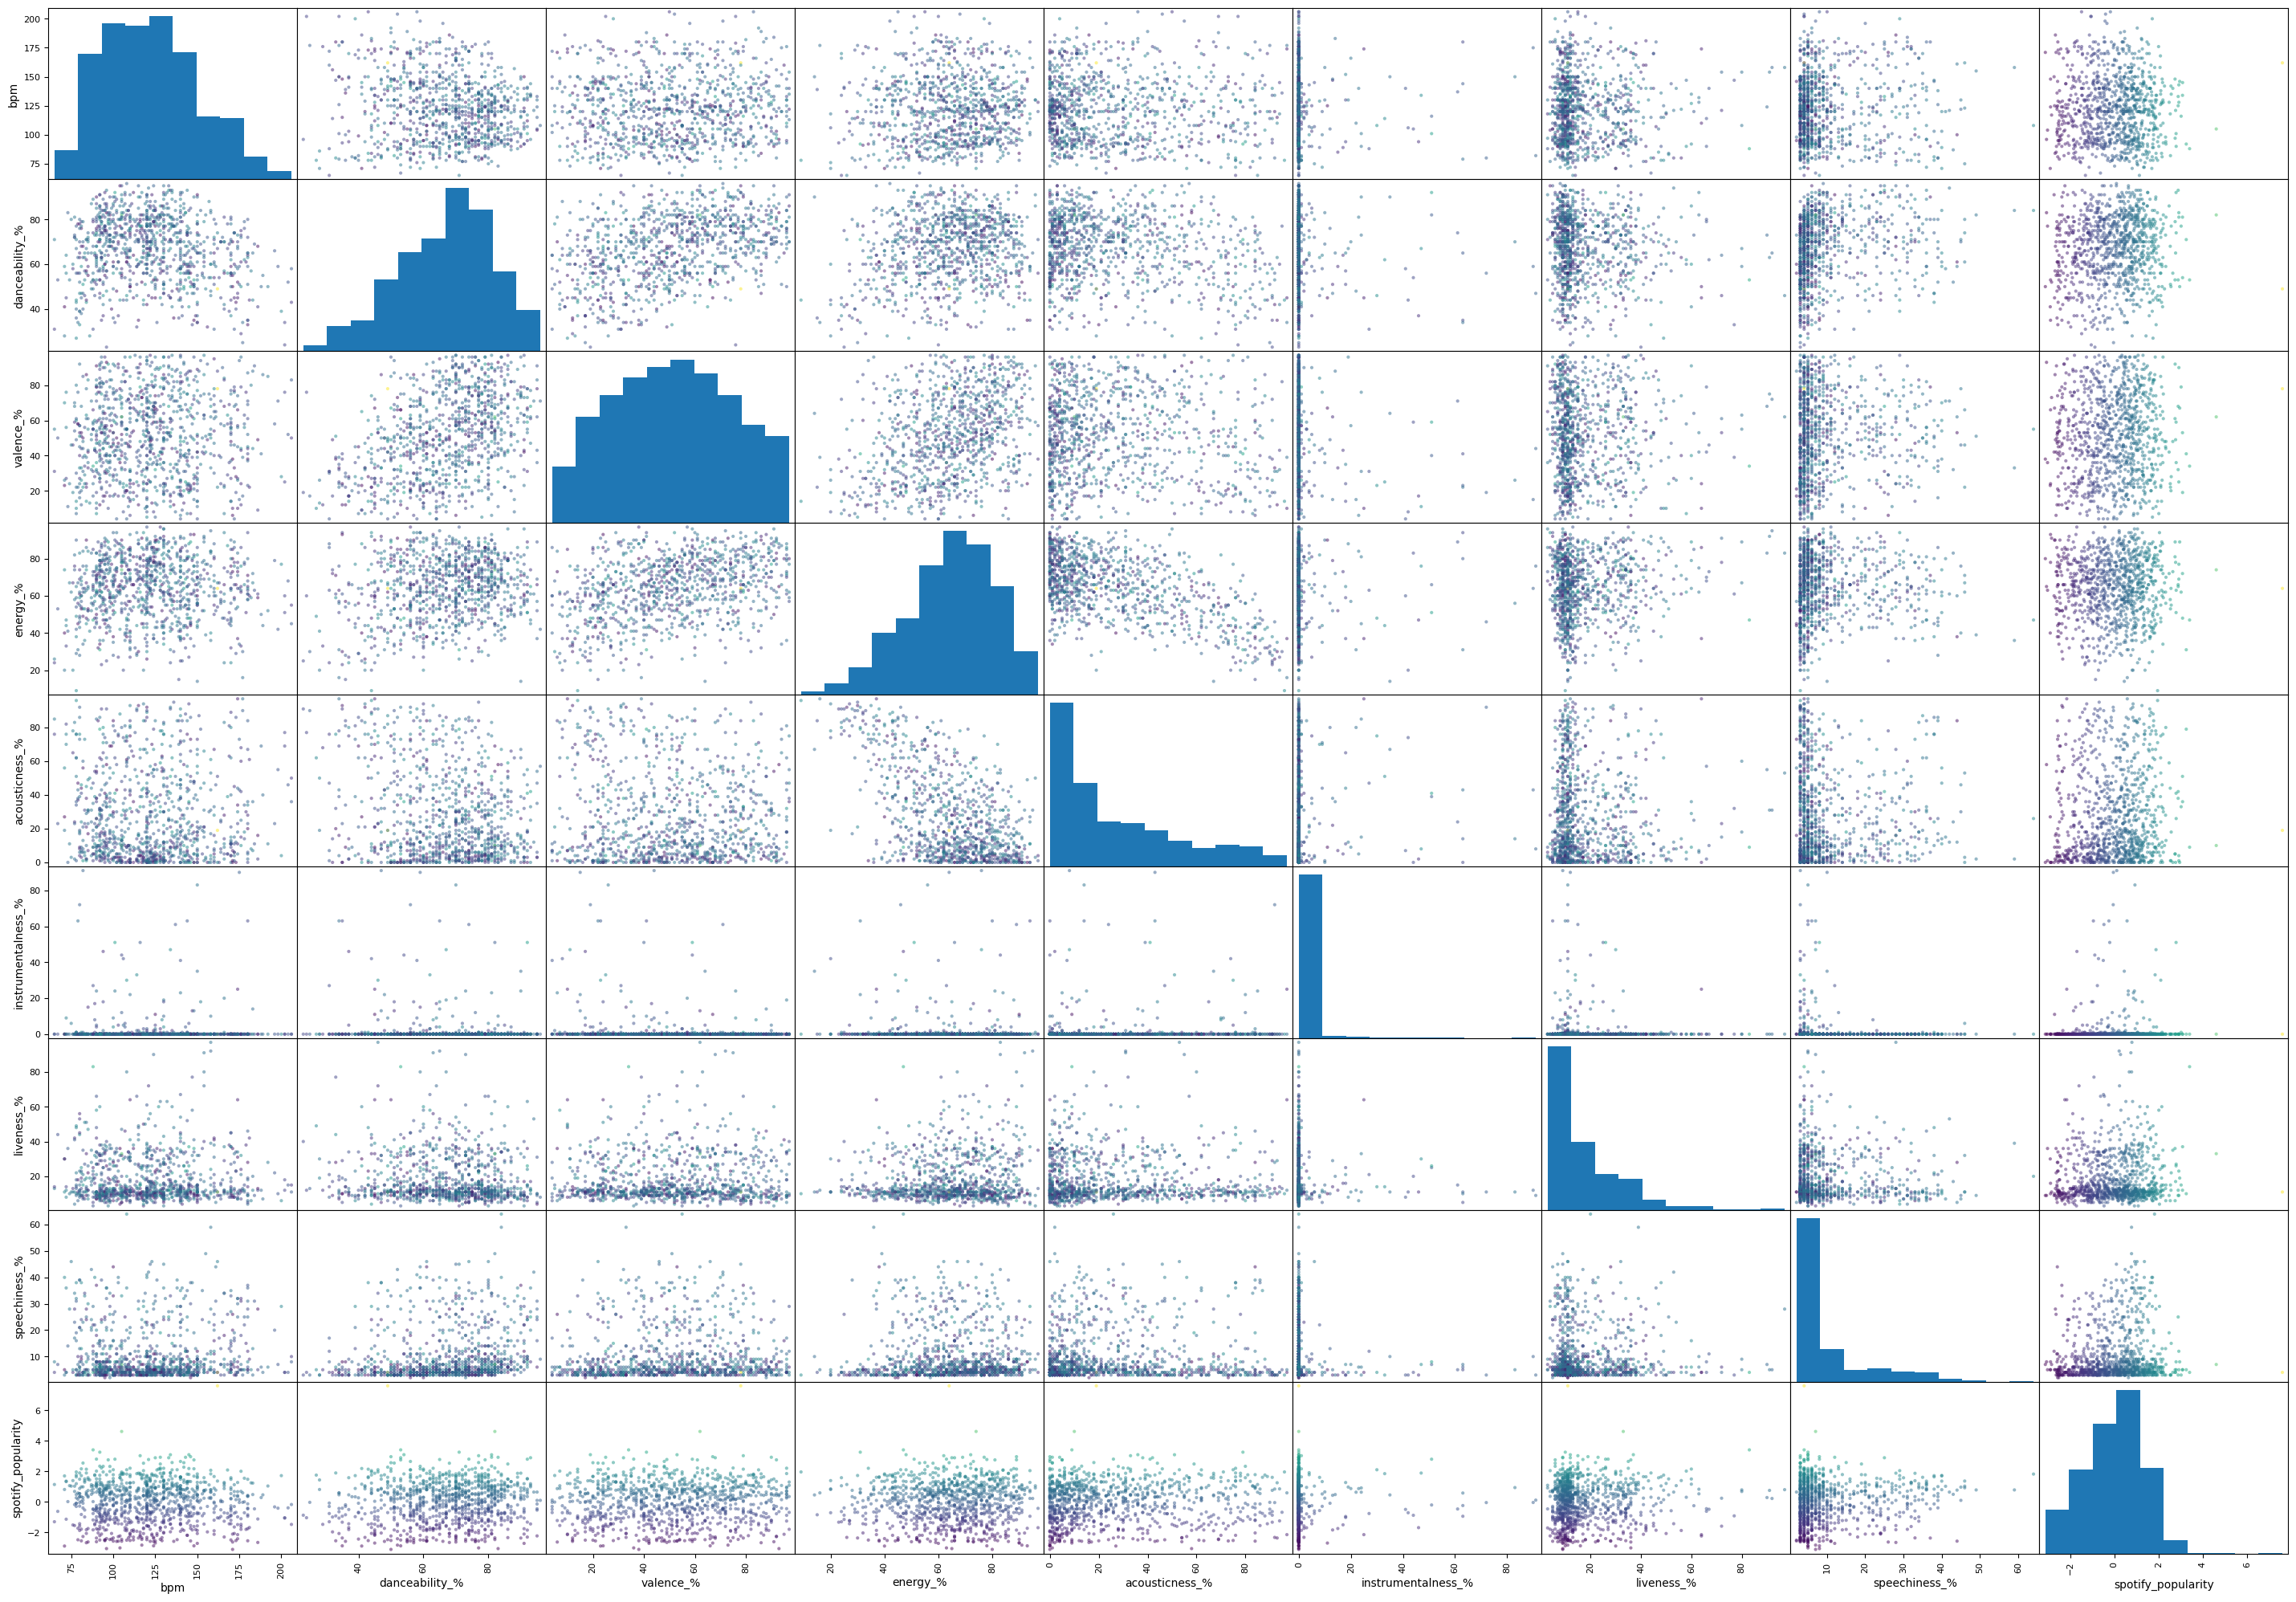

In [9]:
musical_attribute_numerical_features = list(filter(lambda feature: feature == "bpm" or "_%" in feature, musical_attribute_features))
musical_attribute_numerical_features.append('spotify_popularity')

fig, axs = plt.subplots(1, len(musical_attribute_numerical_features), figsize=(16, 9))

print("Feature Name", "Min", "Avg", "Max")
for feature_index in range(len(musical_attribute_numerical_features)):
    feature = musical_attribute_numerical_features[feature_index]
    print(feature, data[feature].min(), round(data[feature].mean(), 2), data[feature].max())
    axs[feature_index].boxplot(data[feature])
    axs[feature_index].set_title(feature)

plt.tight_layout()
plt.show()

pd.plotting.scatter_matrix(data[musical_attribute_numerical_features], figsize=(36, 25), c=data['spotify_popularity'], cmap="viridis")

As you can see, bpm, danceability_%, valence_%, and energy_% are all distributed roughly normally. However, acousticness_%, instrumentalness_%, liveness_%, and speechiness_% appear to be skewed towards the lower percentages. Perhaps we can reduce the skewness using another square root transformation.

Feature Name Min Avg Max
bpm 65 122.54 206
danceability_% 23 66.97 96
valence_% 4 51.43 97
energy_% 9 64.28 97
standardized_acousticness_% 0.0 45.46 100.0
standardized_instrumentalness_% 0.0 3.24 100.0
standardized_liveness_% 17.586311452816474 41.02 100.0
standardized_speechiness_% 17.67766952966369 36.37 100.0
spotify_popularity -3.120838571966517 -0.0 7.600037690522802


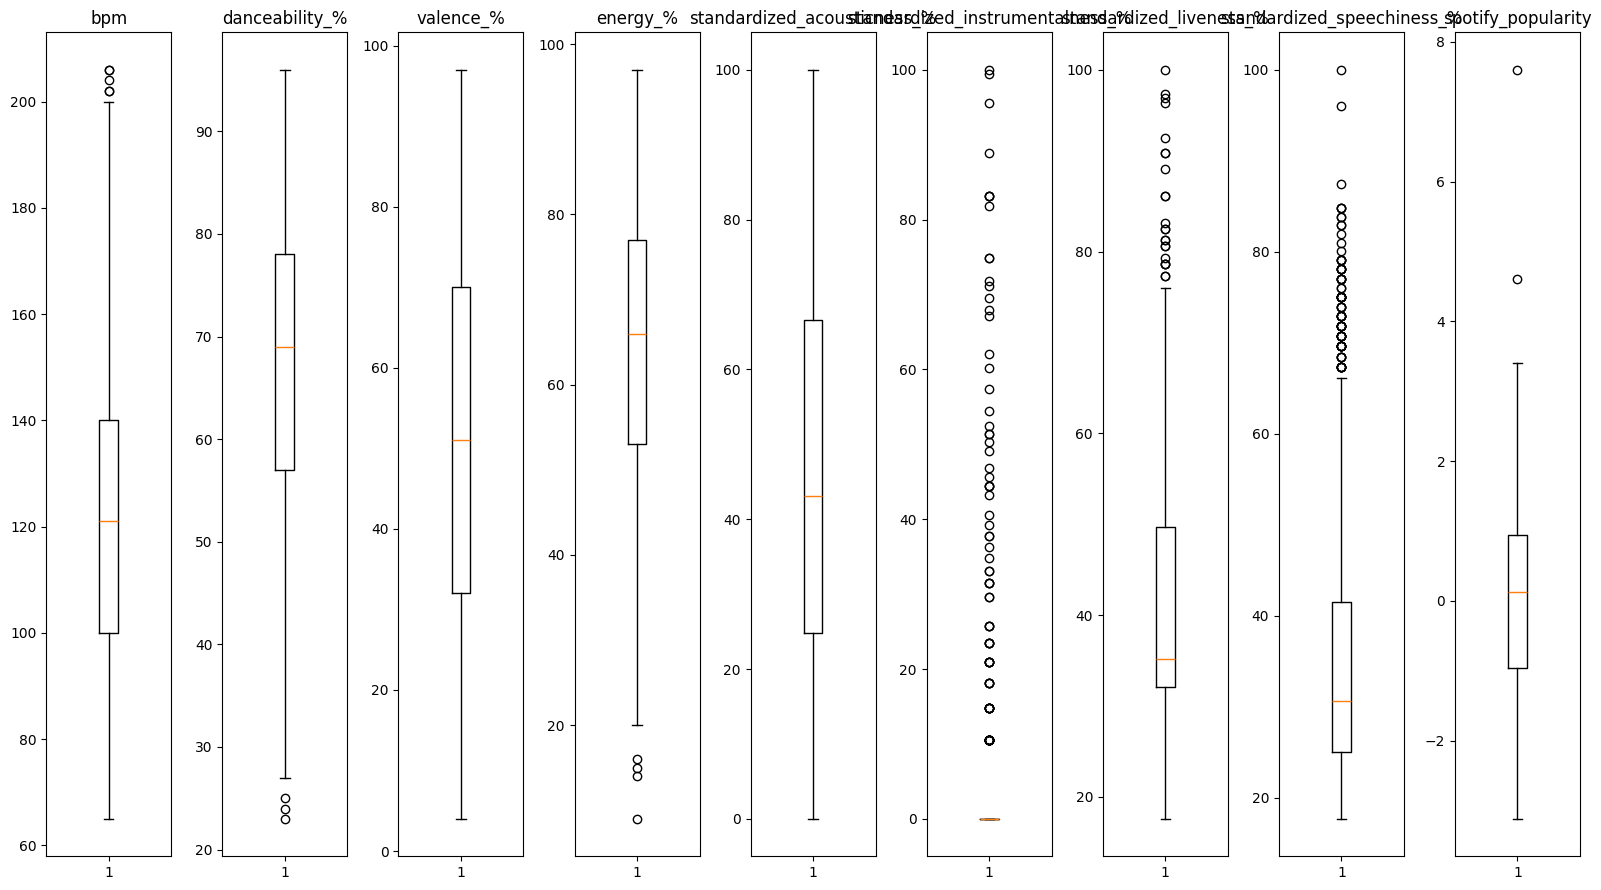

array([[<Axes: xlabel='bpm', ylabel='bpm'>,
        <Axes: xlabel='danceability_%', ylabel='bpm'>,
        <Axes: xlabel='valence_%', ylabel='bpm'>,
        <Axes: xlabel='energy_%', ylabel='bpm'>,
        <Axes: xlabel='standardized_acousticness_%', ylabel='bpm'>,
        <Axes: xlabel='standardized_instrumentalness_%', ylabel='bpm'>,
        <Axes: xlabel='standardized_liveness_%', ylabel='bpm'>,
        <Axes: xlabel='standardized_speechiness_%', ylabel='bpm'>,
        <Axes: xlabel='spotify_popularity', ylabel='bpm'>],
       [<Axes: xlabel='bpm', ylabel='danceability_%'>,
        <Axes: xlabel='danceability_%', ylabel='danceability_%'>,
        <Axes: xlabel='valence_%', ylabel='danceability_%'>,
        <Axes: xlabel='energy_%', ylabel='danceability_%'>,
        <Axes: xlabel='standardized_acousticness_%', ylabel='danceability_%'>,
        <Axes: xlabel='standardized_instrumentalness_%', ylabel='danceability_%'>,
        <Axes: xlabel='standardized_liveness_%', ylabel='danceabili

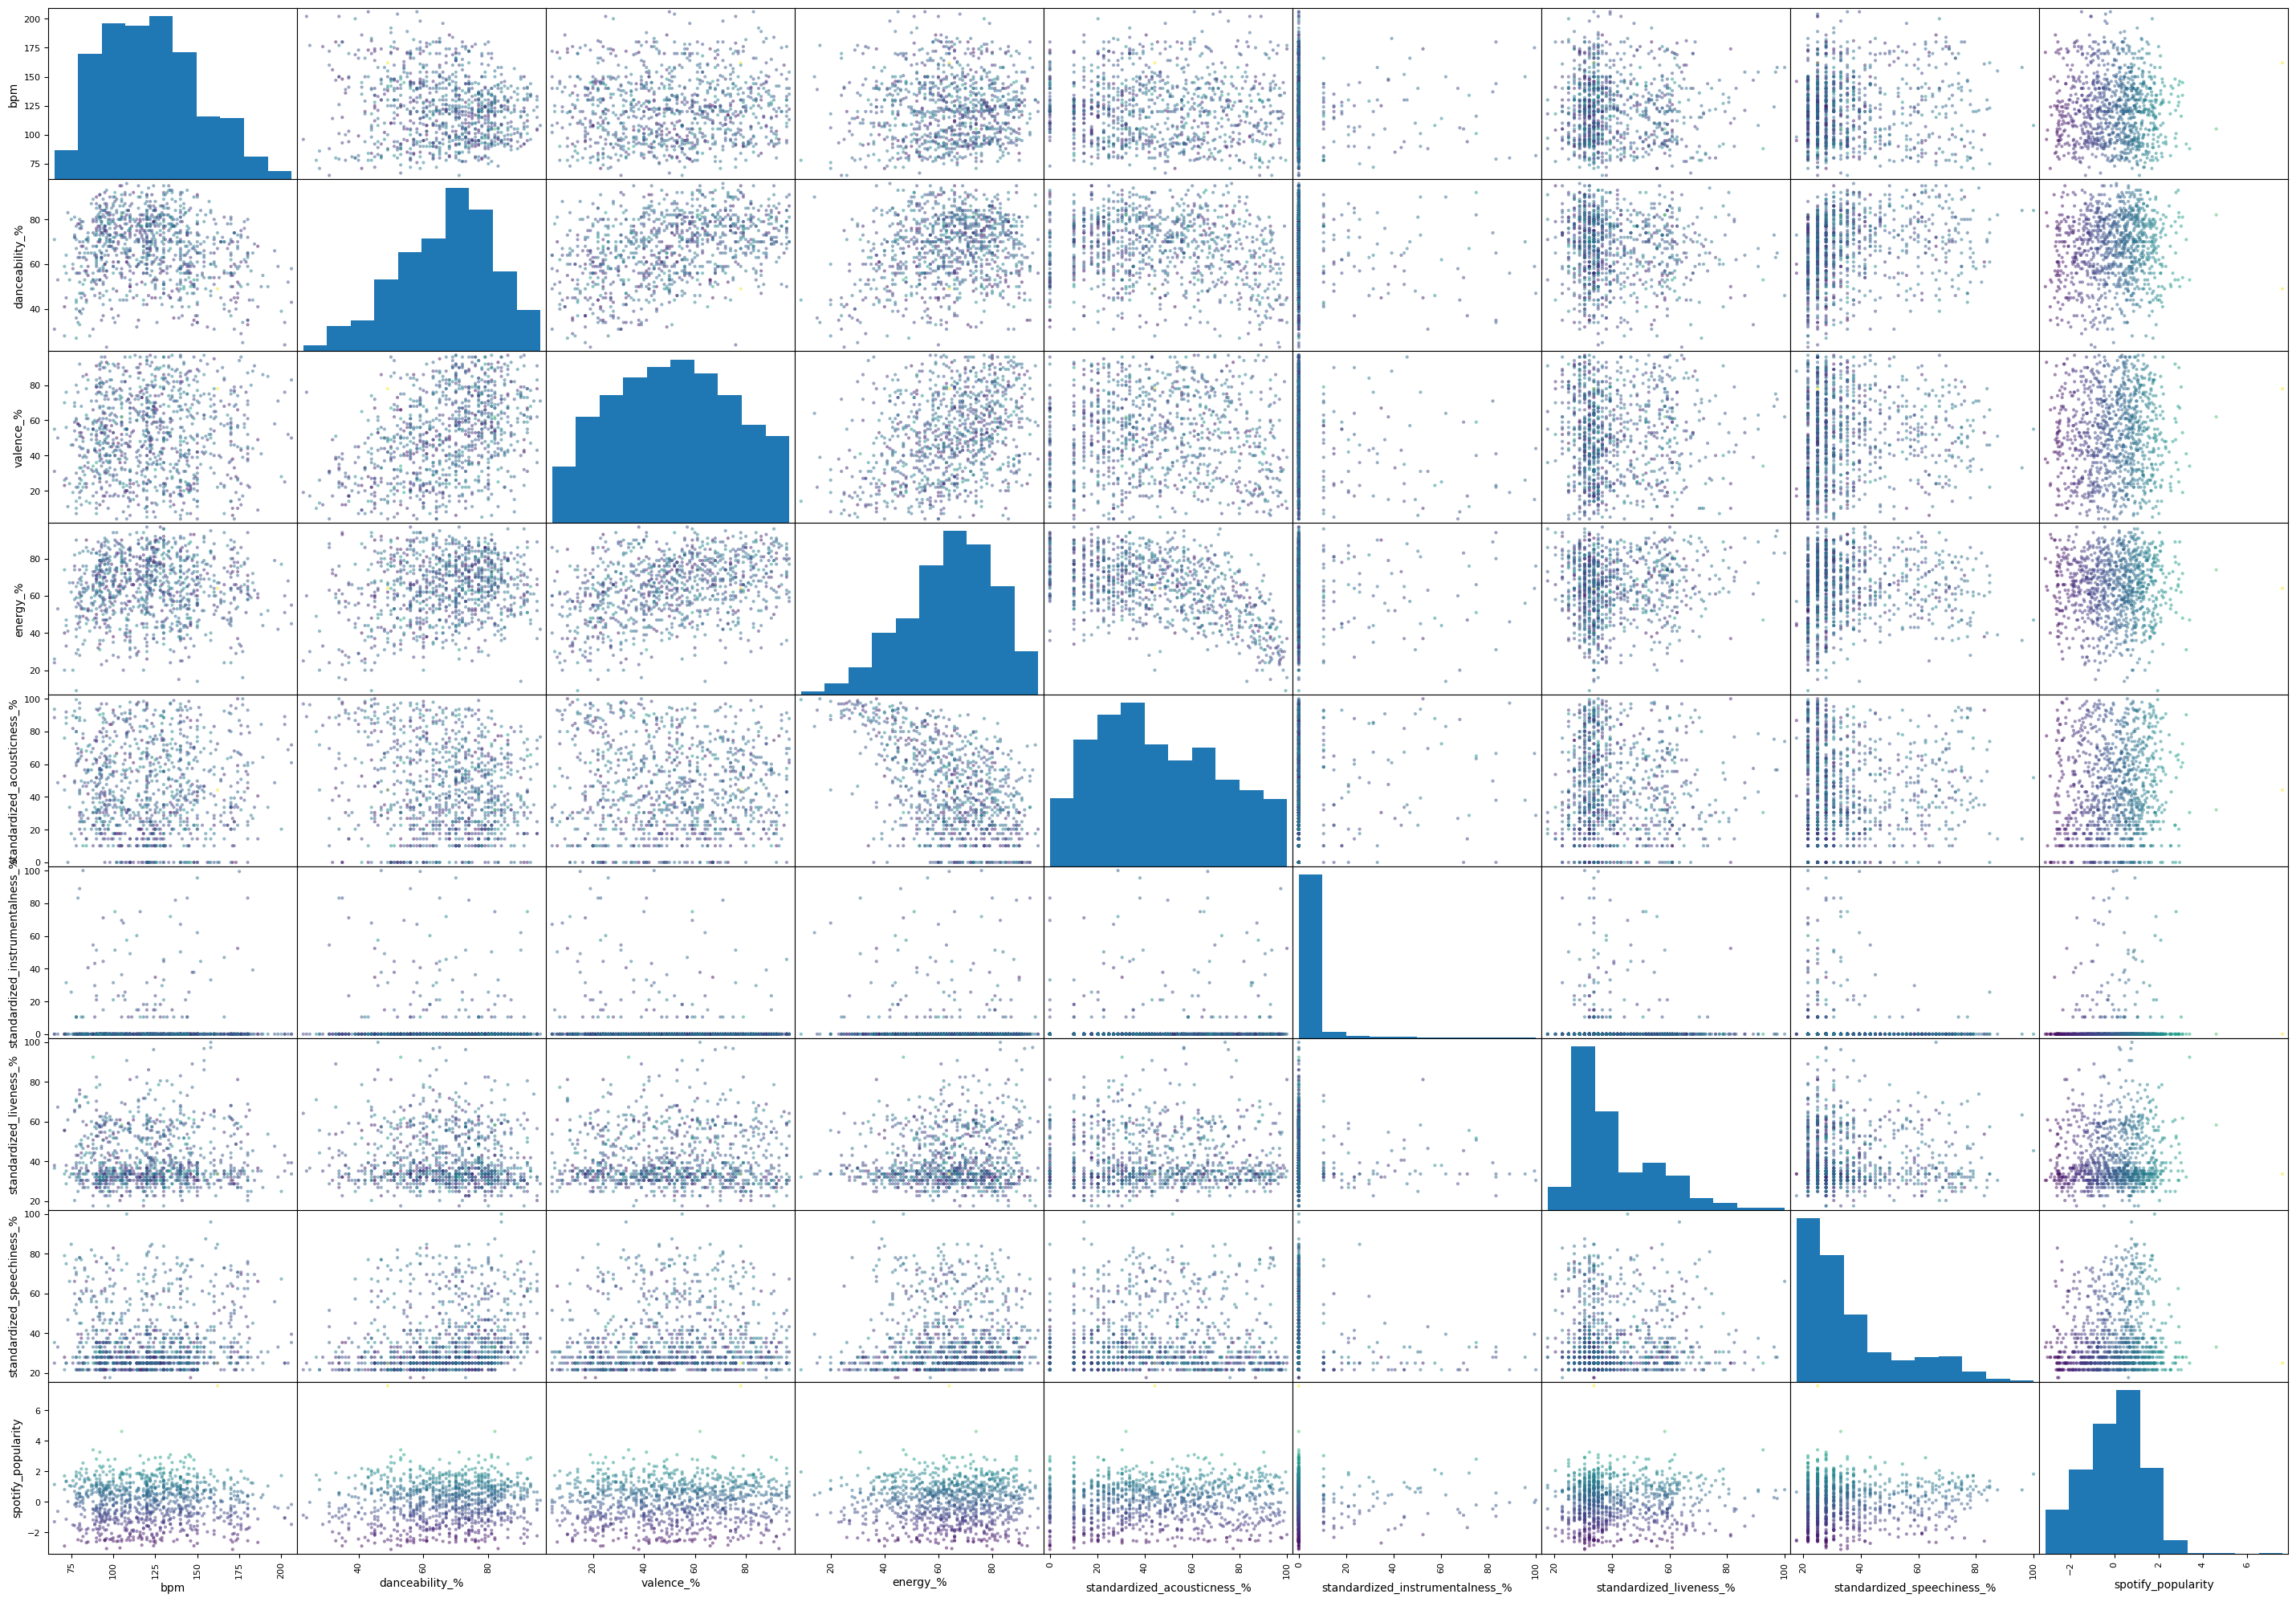

In [10]:
scaler = MaxAbsScaler()

data['standardized_acousticness_%'] = scaler.fit_transform(np.sqrt(data[['acousticness_%']]))*100
data['standardized_instrumentalness_%'] = scaler.fit_transform(np.sqrt(data[['instrumentalness_%']]))*100
data['standardized_liveness_%'] = scaler.fit_transform(np.sqrt(data[['liveness_%']]))*100
data['standardized_speechiness_%'] = scaler.fit_transform(np.sqrt(data[['speechiness_%']]))*100

standardized_musical_attribute_numerical_features = ["bpm", "danceability_%", "valence_%", "energy_%", "standardized_acousticness_%", 'standardized_instrumentalness_%', 'standardized_liveness_%', 'standardized_speechiness_%', "spotify_popularity"]

fig, axs = plt.subplots(1, len(standardized_musical_attribute_numerical_features), figsize=(16, 9))

print("Feature Name", "Min", "Avg", "Max")
for feature_index in range(len(standardized_musical_attribute_numerical_features)):
    feature = standardized_musical_attribute_numerical_features[feature_index]
    print(feature, data[feature].min(), round(data[feature].mean(), 2), data[feature].max())
    axs[feature_index].boxplot(data[feature])
    axs[feature_index].set_title(feature)

plt.tight_layout()
plt.show()

pd.plotting.scatter_matrix(data[standardized_musical_attribute_numerical_features], figsize=(36, 25), c=data['spotify_popularity'], cmap="viridis")

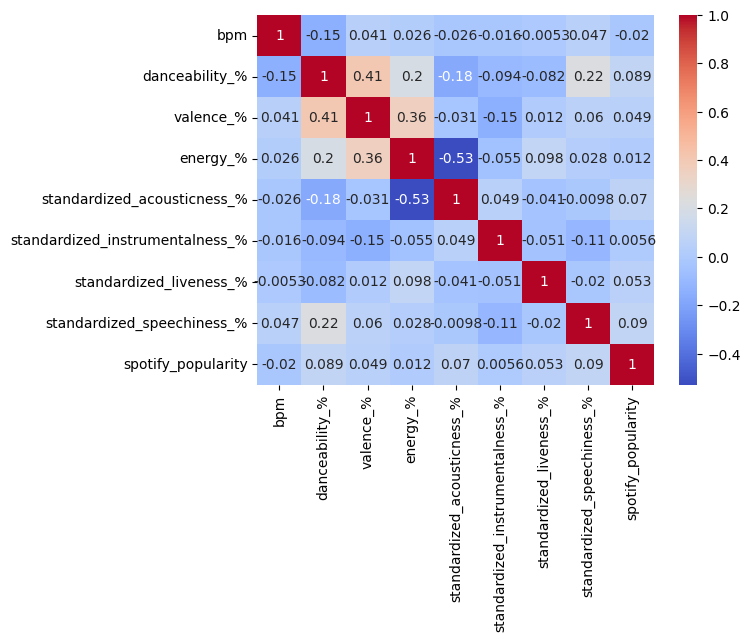

In [11]:
corr_matrix = data[standardized_musical_attribute_numerical_features].corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

In [12]:
X = data[["bpm", "danceability_%", "valence_%", "energy_%", "standardized_acousticness_%", 'standardized_instrumentalness_%', 'standardized_liveness_%', 'standardized_speechiness_%']]
y = data['spotify_popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean-squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean-squared Error (MSE): 1.4749624399516377
R-squared (R2): 0.011554258190445865


In [13]:
model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
y_pred = grid_search.best_estimator_.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean-squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Best params: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}
Mean-squared Error (MSE): 1.4828854147433819
R-squared (R2): 0.006244678445743612


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=None)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio per component:")
print(explained_variance)

cumulative_variance = np.cumsum(explained_variance)
print("Cumulative explained variance ratio:")
print(cumulative_variance)

Explained variance ratio per component:
[0.24123694 0.1574198  0.13501352 0.12701802 0.11688028 0.10915856
 0.0717151  0.04155778]
Cumulative explained variance ratio:
[0.24123694 0.39865674 0.53367026 0.66068827 0.77756856 0.88672712
 0.95844222 1.        ]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean-squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean-squared Error (MSE): 1.4749624399516377
R-squared (R2): 0.011554258190445865


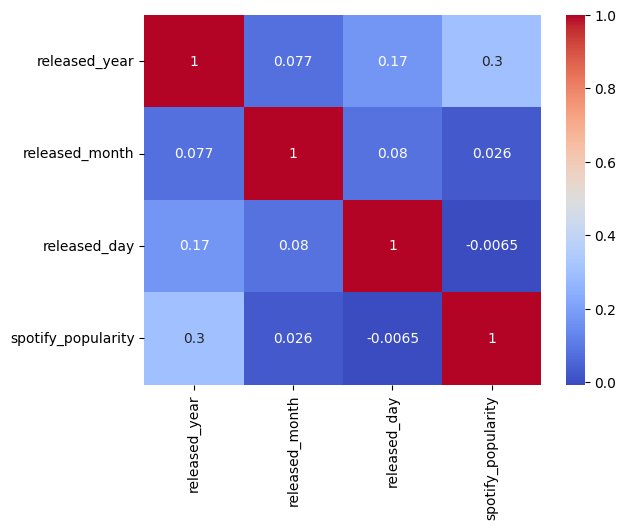

Mean-squared Error (MSE): 1.3796814591781354
R-squared (R2): 0.07540678566504


array([[<Axes: xlabel='released_year', ylabel='released_year'>,
        <Axes: xlabel='spotify_popularity', ylabel='released_year'>],
       [<Axes: xlabel='released_year', ylabel='spotify_popularity'>,
        <Axes: xlabel='spotify_popularity', ylabel='spotify_popularity'>]],
      dtype=object)

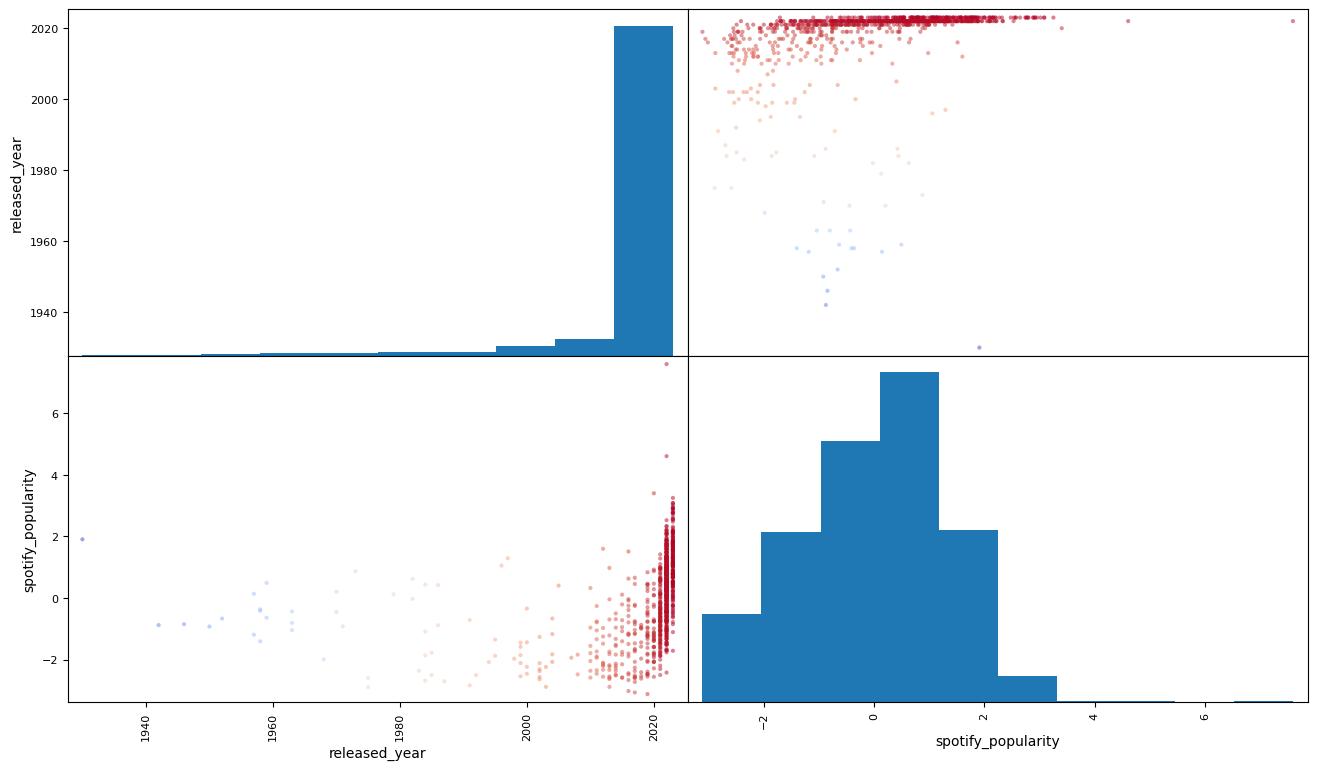

In [31]:
release_information_features = ["released_year", "released_month", "released_day", "spotify_popularity"]
corr_matrix = data[release_information_features].corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()


X_train, X_test, y_train, y_test = train_test_split(data[["released_year"]], y, test_size=0.2, random_state=42)
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean-squared Error (MSE):", mse)
print("R-squared (R2):", r2)

pd.plotting.scatter_matrix(data[["released_year", "spotify_popularity"]], figsize=(16, 9), c=data['released_year'], cmap="coolwarm")

Last Yearly Average:  released_year
2023    124.062857
Name: bpm, dtype: float64
Last 3-Year Running Average:  released_year
2023    123.966588
Name: bpm, dtype: float64
Overall Average:  121.62322004603162


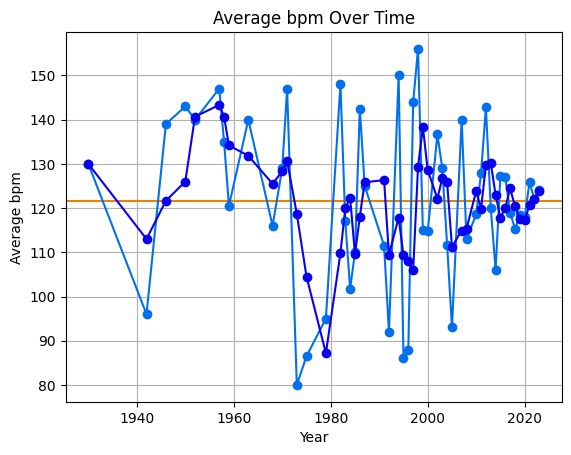

Last Yearly Average:  released_year
2023    70.022857
Name: danceability_%, dtype: float64
Last 3-Year Running Average:  released_year
2023    68.973887
Name: danceability_%, dtype: float64
Overall Average:  59.06256150411609


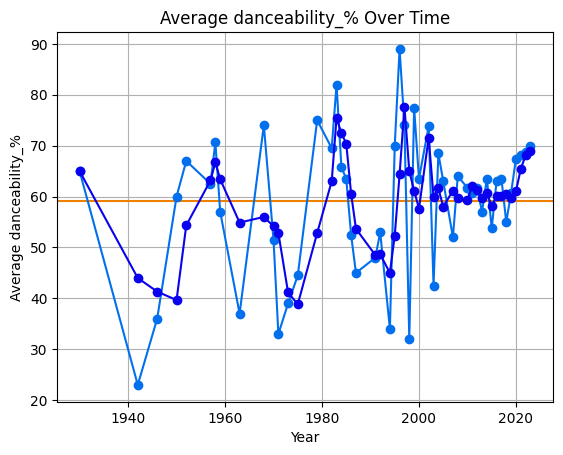

Last Yearly Average:  released_year
2023    55.08
Name: valence_%, dtype: float64
Last 3-Year Running Average:  released_year
2023    53.030353
Name: valence_%, dtype: float64
Overall Average:  53.092171671442614


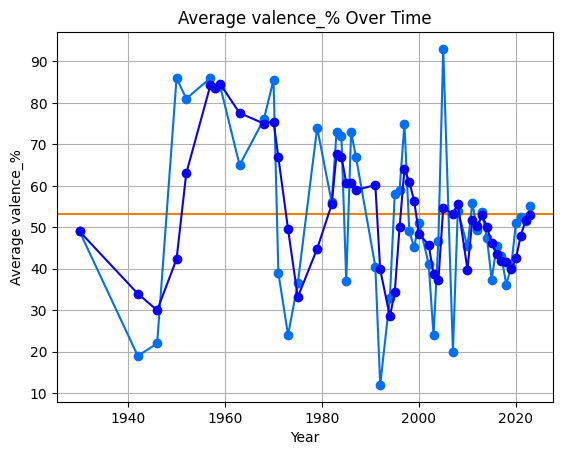

Last Yearly Average:  released_year
2023    68.222857
Name: energy_%, dtype: float64
Last 3-Year Running Average:  released_year
2023    65.231901
Name: energy_%, dtype: float64
Overall Average:  61.4454488804002


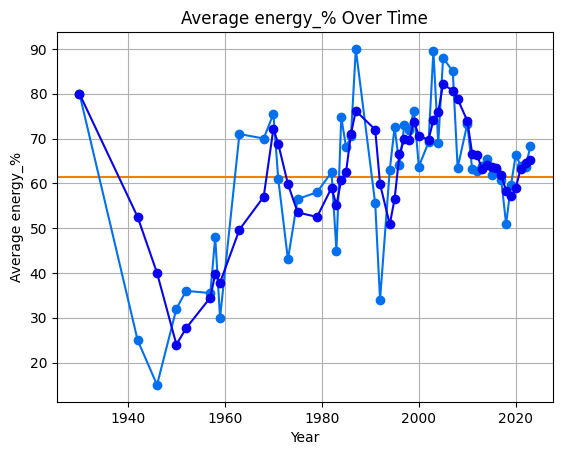

Last Yearly Average:  released_year
2023    25.251429
Name: acousticness_%, dtype: float64
Last 3-Year Running Average:  released_year
2023    25.992278
Name: acousticness_%, dtype: float64
Overall Average:  30.86334505032603


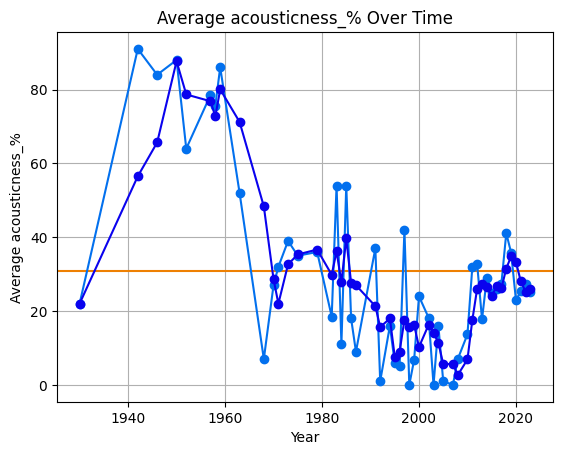

Last Yearly Average:  released_year
2023    1.205714
Name: instrumentalness_%, dtype: float64
Last 3-Year Running Average:  released_year
2023    1.099502
Name: instrumentalness_%, dtype: float64
Overall Average:  2.024026622587114


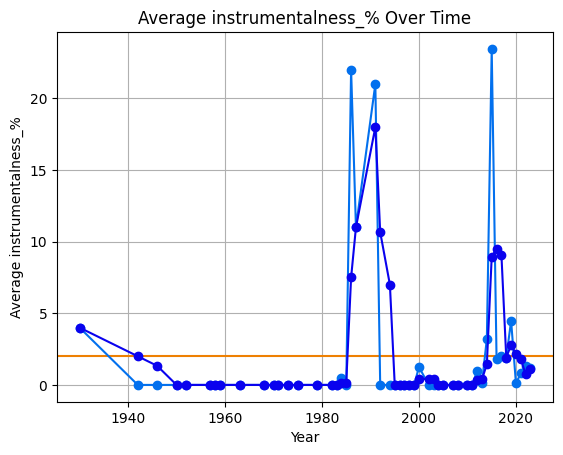

Last Yearly Average:  released_year
2023    19.742857
Name: liveness_%, dtype: float64
Last 3-Year Running Average:  released_year
2023    18.364179
Name: liveness_%, dtype: float64
Overall Average:  18.32399263075837


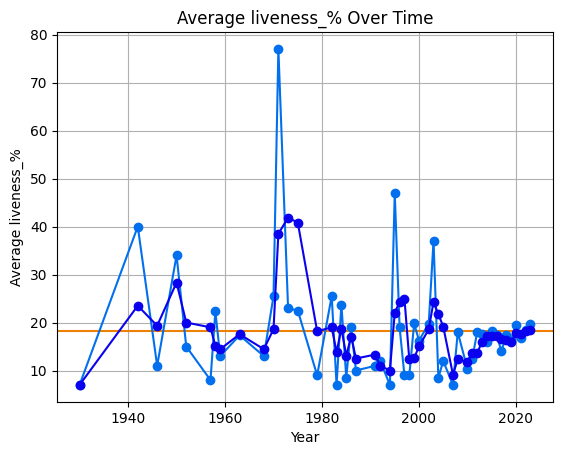

Last Yearly Average:  released_year
2023    9.297143
Name: speechiness_%, dtype: float64
Last 3-Year Running Average:  released_year
2023    10.845058
Name: speechiness_%, dtype: float64
Overall Average:  6.1133162560670815


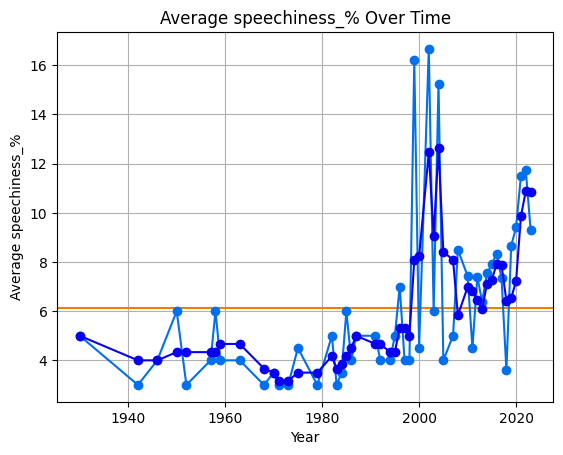

Last Yearly Average:  released_year
2023    1.186169
Name: spotify_popularity, dtype: float64
Last 3-Year Running Average:  released_year
2023    0.384666
Name: spotify_popularity, dtype: float64
Overall Average:  -1.0447396033732617


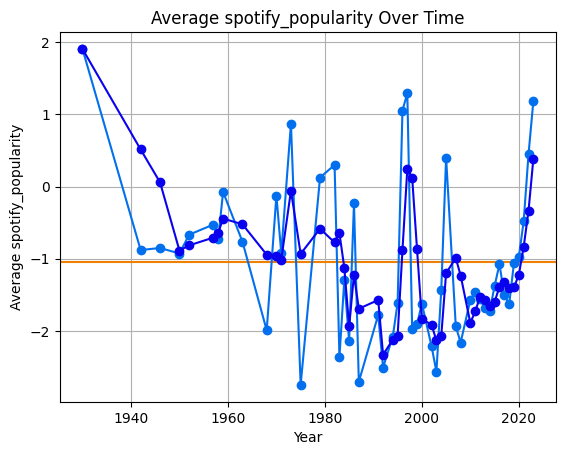

In [43]:
for feature in musical_attribute_numerical_features:
    
    yearlyAverage = data.groupby('released_year')[feature].mean()
    runningAverage = yearlyAverage.rolling(window=3,  min_periods=1).mean()
    overallAverage = yearlyAverage.mean()

    print("Last Yearly Average: ", yearlyAverage.tail(1))
    print("Last 3-Year Running Average: ", runningAverage.tail(1))
    print("Overall Average: ", overallAverage)
    
    plt.axhline(y=overallAverage, linestyle='-', label='Overall Average', color='#ee8002')
    plt.plot(yearlyAverage.index, yearlyAverage.values, marker='o', linestyle='-', label='Yearly Average', color='#0270ee')
    plt.plot(runningAverage.index, runningAverage.values, marker='o', linestyle='-', label='3-Year Running Average', color='#0a02ee')
    
    plt.title('Average ' + feature + ' Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average ' + feature)
    plt.grid(True)
    plt.show()